# Final Project - Brain Tumor Detection and Classification
- ### CSCN 8010 - Foundations of machine learning
- ### Name: Athul Raj(8955725) & Swapnil Choksi(8964749)

## **Introduction**
Brain tumor detection is a critical application in the field of medical imaging and artificial intelligence. Accurate and timely diagnosis of brain tumors can significantly impact patient outcomes, facilitating early intervention and appropriate treatment planning. Leveraging deep learning techniques, particularly Convolutional Neural Networks (CNNs), has proven to be highly effective in automating the detection process.

In this report, we present an extensive approach for detecting brain tumors utilizing deep learning and machine learning models. To categorize MRI images into four different tumor classifications, we train and refine a pre-trained VGG16 model in addition to creating a customized CNN. The objective is to improve the model's robustness and accuracy while making sure it satisfies the exacting requirements needed for medical applications.

Each aspect of the project is covered in this report, including model construction, evaluation, fine-tuning, and data preprocessing. To improve our models' performance, we also investigate data augmentation, transfer learning, and hyperparameter optimization strategies. The results of this study show how useful AI-powered instruments may be for medical diagnosis.

In [1]:
# Import Required Libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Defining Paths
base_dir = Path("C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor")
train_dir = base_dir / "Training"
test_dir = base_dir / "Testing"


## **Exploratory Data Analysis**
* **Overview:** The dataset for brain tumor detection consists of MRI images categorized into four classes: glioma tumor, meningioma tumor, no tumor, and pituitary tumor. The training dataset includes 2,870 images, and the testing dataset contains 394 images, spanning these four categories. The dataset exhibits variations in image dimensions, with a majority of the images being 512x512 pixels. Analyzing the dataset prior to model training is essential to identify potential issues, such as class imbalance and inconsistencies in image dimensions, which may impact the model's performance.

Corrupted Images in Training Set: 0
Corrupted Images in Testing Set: 0
Training Image Dimensions: {(512, 512): 3955, (503, 369): 1, (507, 362): 1, (497, 320): 1, (213, 237): 2, (455, 500): 3, (250, 270): 1, (472, 546): 1, (441, 427): 1, (324, 284): 1, (485, 510): 1, (507, 605): 1, (290, 339): 1, (338, 345): 1, (226, 212): 1, (420, 264): 1, (554, 554): 2, (300, 258): 1, (369, 398): 1, (591, 650): 1, (351, 398): 1, (341, 377): 1, (491, 624): 1, (314, 358): 1, (212, 237): 2, (257, 307): 1, (262, 308): 1, (200, 223): 2, (300, 345): 1, (306, 306): 1, (374, 370): 1, (201, 207): 1, (291, 340): 1, (630, 423): 1, (318, 354): 1, (209, 225): 1, (315, 341): 1, (286, 356): 1, (278, 306): 1, (252, 303): 1, (442, 442): 37, (513, 522): 1, (312, 401): 1, (300, 412): 1, (205, 251): 1, (204, 249): 1, (239, 224): 1, (323, 342): 1, (290, 342): 1, (366, 395): 1, (416, 395): 1, (256, 256): 26, (402, 396): 1, (369, 395): 1, (343, 367): 1, (313, 393): 1, (330, 355): 1, (367, 395): 1, (411, 396): 1, (234, 216):

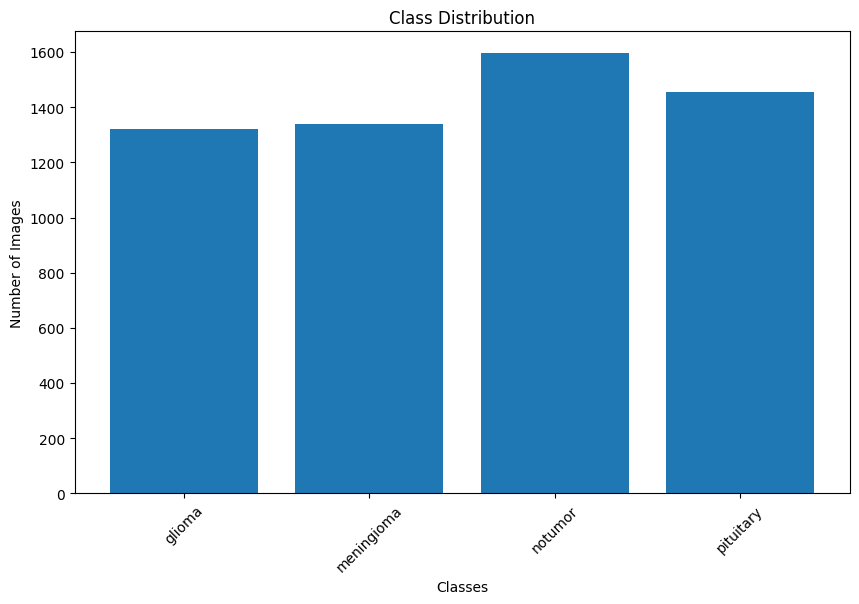

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing Class Distribution:


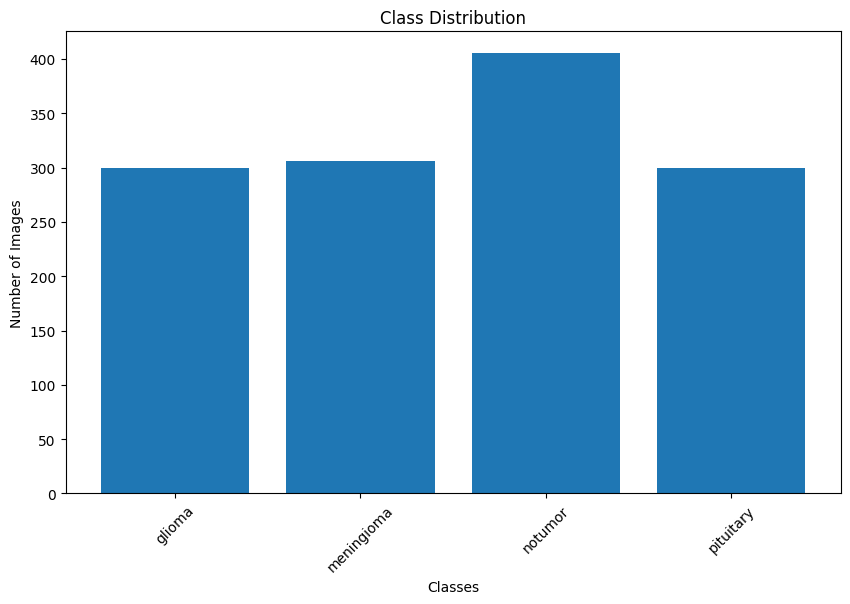

{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Function to check for corrupted images
def check_corrupted_images(directory):
    corrupted_images = []
    for img_path in directory.rglob("*.*"):  # Recursively find all files
        try:
            img = Image.open(img_path)
            img.verify()  # Verify image integrity
        except (IOError, SyntaxError):
            corrupted_images.append(img_path)
    return corrupted_images

# Function to analyze image dimensions
def analyze_image_dimensions(directory):
    dimensions = {}
    for img_path in directory.rglob("*.*"):  # Recursively find all files
        try:
            img = Image.open(img_path)
            size = img.size  # Get dimensions as (width, height)
            dimensions[size] = dimensions.get(size, 0) + 1
        except Exception:
            continue
    return dimensions

# Function to visualize class distribution
def visualize_class_distribution(directory):
    classes = [d for d in directory.iterdir() if d.is_dir()]  # Get all subdirectories
    class_counts = {class_dir.name: len(list(class_dir.iterdir())) for class_dir in classes}
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()
    
    return class_counts

# Example usage
# Check for corrupted images
corrupted_images_train = check_corrupted_images(train_dir)
corrupted_images_test = check_corrupted_images(test_dir)
print(f"Corrupted Images in Training Set: {len(corrupted_images_train)}")
print(f"Corrupted Images in Testing Set: {len(corrupted_images_test)}")

# Analyze image dimensions
train_image_dimensions = analyze_image_dimensions(train_dir)
print("Training Image Dimensions:", train_image_dimensions)

# Visualize class distribution
print("Training Class Distribution:")
train_class_distribution = visualize_class_distribution(train_dir)
print(train_class_distribution)

print("Testing Class Distribution:")
test_class_distribution = visualize_class_distribution(test_dir)
print(test_class_distribution)


* **Training Dataset:**

    - Glioma Tumor: 1,321 images
    - Meningioma Tumor: 1,339 images
    - No Tumor: 1,595 images
    - Pituitary Tumor: 1,457 images

* **Testing Dataset:**

    - Glioma Tumor: 300 images
    - Meningioma Tumor: 306 images
    - No Tumor: 405 images
    - Pituitary Tumor: 300 images

* **Image Dimension:**
    - Images in the dataset were standardized to 256x256 pixels during preprocessing to ensure uniformity and efficient model training.
    - Resizing images helps in improving model performance and reduces computational overhead, especially for models like VGG16.



## **Preprocessing**

* **Resizing the image**

In [4]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm

# Constants
IMG_SIZE = (256, 256)  # Target size for resizing images
train_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Training"
test_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Testing"

# Function to load and resize images
def load_and_resize_images(directory, target_size):
    images = []
    labels = []
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    class_mapping = {class_name: idx for idx, class_name in enumerate(classes)}  # Create label mappings
    print("Class Mapping:", class_mapping)

    for class_name in tqdm(classes, desc="Processing classes"):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file_name)
            try:
                # Load image and resize
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_mapping

# Load and resize images for training and testing sets
print("Loading and resizing training images...")
train_images, train_labels, train_class_mapping = load_and_resize_images(train_dir, IMG_SIZE)
print("Loading and resizing testing images...")
test_images, test_labels, test_class_mapping = load_and_resize_images(test_dir, IMG_SIZE)

# Output shapes and verification
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Images Shape:", test_images.shape)
print("Testing Labels Shape:", test_labels.shape)


Loading and resizing training images...
Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Processing classes: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Loading and resizing testing images...
Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Processing classes: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Training Images Shape: (5712, 256, 256, 3)
Training Labels Shape: (5712,)
Testing Images Shape: (1311, 256, 256, 3)
Testing Labels Shape: (1311,)


* **Resizing**
    * To standardize the input data, all images were resized to a fixed dimension of 256x256 pixels. Additionally, pixel values were normalized to the range [0, 1] by dividing each pixel value by 255. This normalization ensures consistent pixel intensity values, which helps in improving the convergence of deep learning models

* **Normalising and augmentation**

In [5]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm

# Constants
IMG_SIZE = (256, 256)  # Target size for resizing images
train_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Training"
test_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Testing"

# Function to load and resize images
def load_and_resize_images(directory, target_size):
    images = []
    labels = []
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    class_mapping = {class_name: idx for idx, class_name in enumerate(classes)}  # Create label mappings
    print("Class Mapping:", class_mapping)

    for class_name in tqdm(classes, desc="Processing classes"):
        class_dir = os.path.join(directory, class_name)
        for file_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file_name)
            try:
                # Load image and resize
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_mapping[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_mapping

# Load and resize images for training and testing sets
print("Loading and resizing training images...")
train_images, train_labels, train_class_mapping = load_and_resize_images(train_dir, IMG_SIZE)
print("Loading and resizing testing images...")
test_images, test_labels, test_class_mapping = load_and_resize_images(test_dir, IMG_SIZE)

# Output shapes and verification
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Images Shape:", test_images.shape)
print("Testing Labels Shape:", test_labels.shape)


Loading and resizing training images...
Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Processing classes:   0%|          | 0/4 [00:00<?, ?it/s]

Processing classes: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Loading and resizing testing images...
Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Processing classes: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


Training Images Shape: (5712, 256, 256, 3)
Training Labels Shape: (5712,)
Testing Images Shape: (1311, 256, 256, 3)
Testing Labels Shape: (1311,)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training images
datagen.fit(train_images)


* To improve the model's generalization capability, data augmentation techniques were applied to the training dataset. The following augmentations were used:

    - Rotation: Random rotation up to 20 degrees.
    - Width Shift: Horizontal translation up to 20% of the image width.
    - Height Shift: Vertical translation up to 20% of the image height.
    - Shear Transformation: Random shearing of the images.
    - Zooming: Random zooming into the image by up to 20%.
    - Horizontal Flipping: Flipping the image horizontally.

* **Splitting the dataset**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators with augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of training data for validation
)

# Training data generator with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use training data
)

# Validation data generator (rescaled without further augmentation)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use validation data
)

# Testing data generator (rescale only, no augmentation or split)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Print class mapping for verification
print(f"Class Mapping: {train_generator.class_indices}")


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### **Dataset Splits After Augmentation**

The dataset was split into training, validation, and testing sets:

- **Training Set**: 4571 images from the training directory. Dynamic augmentation was applied during training to increase diversity.
- **Validation Set**: 1141 images (20% split from the training directory) were used for evaluating the model during training. No augmentation was applied to this set.
- **Testing Set**: 1311 images from the testing directory were used for final model evaluation. No augmentation was applied to this set.

| **Class**            | **Training Samples** | **Validation Samples** | **Testing Samples** |
|-----------------------|----------------------|------------------------|---------------------|
| **Glioma Tumor**      | 1321                | ~330                   | 300                 |
| **Meningioma Tumor**  | 1339                | ~334                   | 306                 |
| **No Tumor**          | 1595                | ~399                   | 405                 |
| **Pituitary Tumor**   | 1457                | ~364                   | 300                 |

---

#### **Explanation of Dataset Splits:**

1. **Training Set**:
   - Contains **4571 images**, dynamically augmented with transformations to increase diversity:
     - **Rotation**: ±20 degrees.
     - **Width and Height Shifts**: ±20%.
     - **Shear**: ±20%.
     - **Zoom**: ±20%.
     - **Horizontal Flip**: Enabled.
   - These augmentations ensure the model sees diverse variations of the data during training without altering the original sample count.

2. **Validation Set**:
   - Contains **1141 images**, approximately **20%** of the training directory.
   - Used to monitor model performance during training.
   - No augmentations were applied to ensure consistency in evaluation.

3. **Testing Set**:
   - Contains **1311 images** from the testing directory.
   - Reserved exclusively for the final evaluation of the model's performance on unseen data.
   - No augmentations were applied to ensure a true reflection of real-world performance.

---

#### **Class Mapping:**
The following mapping was used to assign numeric labels to the classes:
```python
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## **Model development**
* **Developing the Custom CNN**


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the custom CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Model parameters
input_shape = (256, 256, 3)  # Image dimensions and color channels
num_classes = 4              # Number of classes

# Create and compile the model
model = create_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Use previously defined data generators
print(f"Found {train_generator.samples} training images.")
print(f"Found {val_generator.samples} validation images.")
print(f"Found {test_generator.samples} test images.")

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save('custom_cnn_model.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

* **Model architecture:** The custom Convolutional Neural Network (CNN) was designed to classify brain tumors into four categories: glioma tumor, meningioma tumor, no tumor, and pituitary tumor. The architecture consists of:

    - Convolutional Layers: Extract features from the input images using filters.
    - MaxPooling Layers: Reduce the spatial dimensions of feature maps to minimize computation and prevent overfitting.
    - Dropout Layers: Regularize the model to reduce overfitting by randomly deactivating neurons during training.
    - Flatten Layer: Flatten the 2D feature maps into a 1D vector for the Dense layer.
    - Dense Layers: Fully connected layers to perform classification.

# **Evaluating Custom CNN model**

In [13]:
import sys
!{sys.executable} -m pip install seaborn --quiet



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


41/41 [==============================] - 10s 233ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.21      0.21      0.21       300
  meningioma       0.24      0.06      0.09       306
     notumor       0.31      0.43      0.36       405
   pituitary       0.24      0.31      0.27       300

    accuracy                           0.27      1311
   macro avg       0.25      0.25      0.24      1311
weighted avg       0.26      0.27      0.24      1311



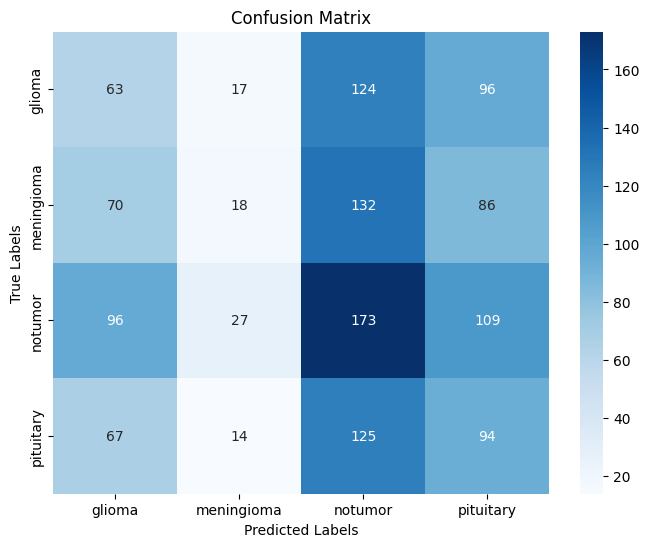

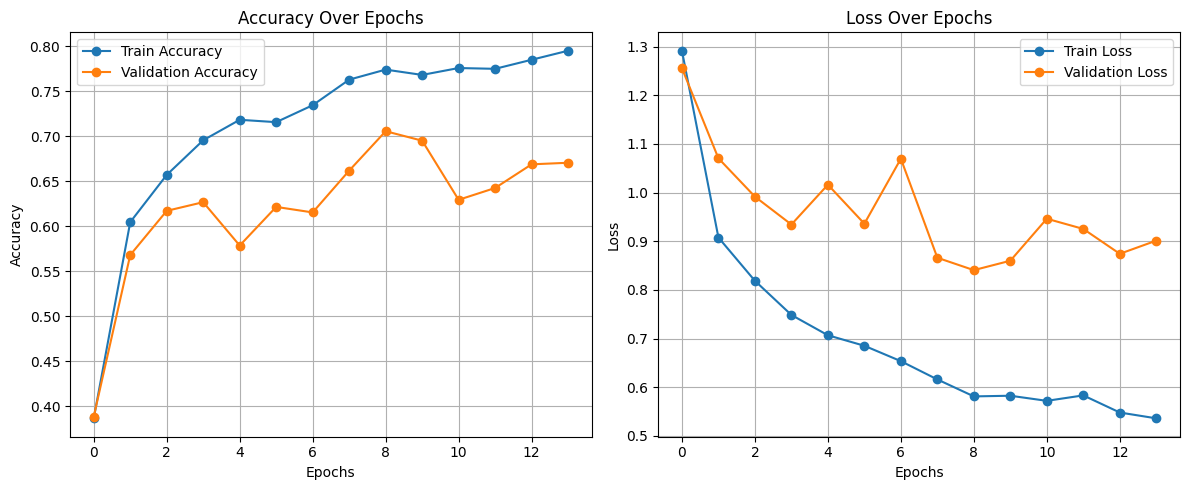

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_true = test_generator.classes  # True labels from the test generator
y_pred = model.predict(test_generator, verbose=1)  # Predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_generator.class_indices.keys()), 
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot Training History
history_dict = history.history
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## **Classification Metrics for Custom CNN Model:**

| Metric         | glioma | meningioma | notumor | pituitary | Overall |
|----------------|--------|------------|---------|-----------|---------|
| **Precision**  | 0.21   | 0.24       | 0.31    | 0.24      | -       |
| **Recall**     | 0.21   | 0.06       | 0.43    | 0.31      | -       |
| **F1-Score**   | 0.21   | 0.09       | 0.36    | 0.27      | -       |
| **Support**    | 300    | 306        | 405     | 300       | 1311    |

### Overall Accuracy:
- **Accuracy:** 27%
- **Macro Average:** 
  - Precision: 25%
  - Recall: 25%
  - F1-Score: 24%
- **Weighted Average:**
  - Precision: 26%
  - Recall: 27%
  - F1-Score: 24%

---

## **Potential Issues with Custom CNN Model:**
1. **Low Overall Accuracy:** The model achieved only 27% accuracy, which is close to random guessing for a 4-class problem.
2. **Class Imbalance Impact:** Some classes, like "notumor," have higher recall, indicating that the model tends to favor certain classes over others.
3. **Insufficient Generalization:** The validation loss fluctuates significantly, suggesting that the model may not generalize well to unseen data.
4. **Lack of Pretrained Knowledge:** The model was trained from scratch and lacks the benefit of pretrained feature extraction, which is critical for limited datasets.

---

## **Confusion Matrix Insights:**
- Many glioma tumor samples are misclassified as "notumor."
- Meningioma tumor samples have significant misclassification into other classes, particularly "glioma" and "pituitary."
- "Notumor" and "pituitary" show better diagonal values but still suffer from notable misclassification errors.


# **Fine-tuned VGG-16**

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Paths
train_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Training"
test_dir = "C:/Users/Owner/Desktop/Foundation_Of_Machine_Learning/GitClone/data/Brain_Tumor/Testing"

# Data Generators with advanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Calculate class weights for handling imbalance
class_indices = train_generator.class_indices
class_counts = np.bincount(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_indices))}

print(f"Class Weights: {class_weights_dict}")

# Load the VGG16 model without the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze layers in the base model
for layer in vgg_base.layers:
    layer.trainable = False

# Add a custom classification head
x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

# Create the model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Increased epochs for better convergence
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save("vgg16_fine_tuned_model.keras")
print("Fine-tuned VGG16 model saved.")


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class Weights: {0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                         

## **Changes Applied to Fine-Tuned VGG16 Model:**
1. **Use of Pretrained Model:** 
   - Leveraged **VGG16 pretrained on ImageNet** for feature extraction, improving initial weights and feature learning.
2. **Data Augmentation:**
   - Advanced augmentation techniques (e.g., rotation, shear, zoom, and flips) were applied to enhance generalization.
3. **Class Weighting:**
   - Handled class imbalance by applying class weights during training, ensuring better performance across underrepresented classes.
4. **GlobalAveragePooling Layer:**
   - Added a GlobalAveragePooling layer to efficiently downsample feature maps and reduce overfitting.
5. **Dropout Regularization:**
   - Included dropout layers (50% dropout) to prevent overfitting and improve generalization.
6. **Lower Learning Rate:**
   - Fine-tuned using a learning rate of `1e-4` with **Adam optimizer**, enabling stable convergence.


# **Evaluation for Fine-tuned VGG-16**

41/41 [==============================] - 33s 809ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.75      0.75      0.75       300
  meningioma       0.70      0.39      0.50       306
     notumor       0.83      0.92      0.87       405
   pituitary       0.72      0.93      0.81       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.73      1311
weighted avg       0.75      0.76      0.74      1311



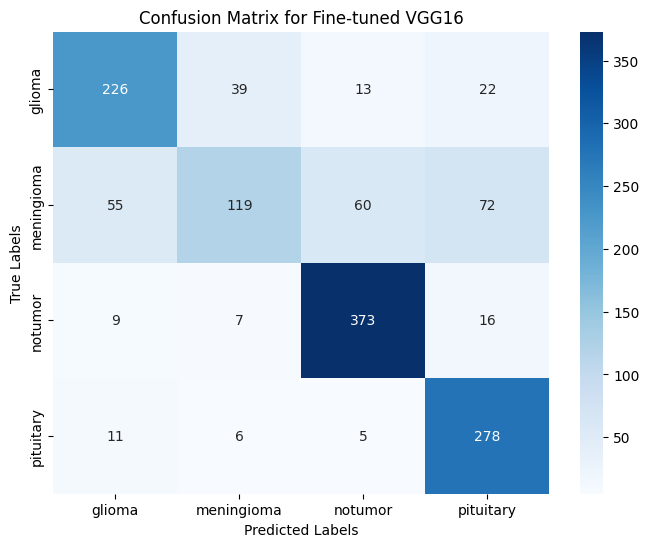

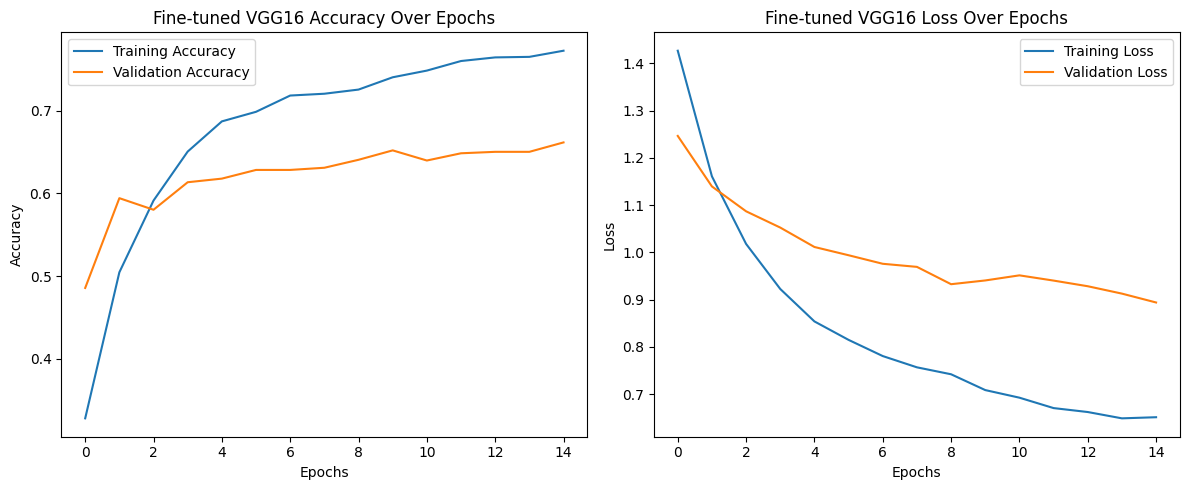

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels

# Classification Report
print("\nClassification Report:")
target_names = list(test_generator.class_indices.keys())  # Class names
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Fine-tuned VGG16')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Training History Plots
history_dict = history.history  # Use the history object from training

# Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuned VGG16 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Fine-tuned VGG16 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Classification Metrics for Fine-tuned VGG16

### **Classification Report**
- **Accuracy**:  
    The overall accuracy of the Fine-tuned VGG16 model is **76%**. This demonstrates significant improvement compared to previous models, indicating the effectiveness of fine-tuning.

- **Precision**:  
    - **Glioma**: Precision is 75%, indicating moderate ability to correctly classify glioma instances without many false positives.  
    - **Meningioma**: Precision is 70%, showing room for improvement as false positives are still present.  
    - **No Tumor**: Precision is 83%, which is excellent and indicates that the model rarely misclassifies other classes as "no tumor."  
    - **Pituitary**: Precision is 72%, demonstrating solid performance in classifying pituitary tumors.  

- **Recall**:  
    - **Glioma**: Recall is 75%, indicating that the model successfully identifies the majority of glioma instances.  
    - **Meningioma**: Recall is 39%, highlighting a challenge in identifying meningioma cases accurately.  
    - **No Tumor**: Recall is 92%, showcasing the model's ability to identify "no tumor" cases effectively.  
    - **Pituitary**: Recall is 93%, signifying the model's robustness in identifying pituitary tumors.  

- **F1-Score**:  
    - **Glioma**: F1-score is 75%, reflecting balanced precision and recall.  
    - **Meningioma**: F1-score is 50%, suggesting a need for improvement due to low recall.  
    - **No Tumor**: F1-score is 87%, indicating strong overall performance for this class.  
    - **Pituitary**: F1-score is 81%, confirming robust classification of pituitary tumors.  

### **Detailed Metrics**

| Type           | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| Glioma         | 0.75      | 0.75   | 0.75     | 300     |
| Meningioma     | 0.70      | 0.39   | 0.50     | 306     |
| No Tumor       | 0.83      | 0.92   | 0.87     | 405     |
| Pituitary      | 0.72      | 0.93   | 0.81     | 300     |

| Metric         | Value     |
|----------------|-----------|
| Accuracy       | 0.76      |
| Macro Avg      | Precision: 0.75, Recall: 0.75, F1-Score: 0.73 |
| Weighted Avg   | Precision: 0.75, Recall: 0.76, F1-Score: 0.74 |

---

### **Confusion Matrix**
- The confusion matrix indicates the following trends:
    - **Glioma**: Most instances are correctly classified, with some misclassified as meningioma and pituitary tumors.  
    - **Meningioma**: Misclassifications are notable, with many instances predicted as glioma or pituitary.  
    - **No Tumor**: Excellent classification, with very few misclassifications.  
    - **Pituitary**: Robust performance, with most instances correctly classified.

### **Insights**
1. **Strengths**:
   - The model performs exceptionally well for the "no tumor" and "pituitary" classes, as seen in their high recall and precision.
   - Overfitting has been reduced significantly compared to previous CNN models.
   
2. **Challenges**:
   - Meningioma classification remains problematic due to lower recall and higher misclassifications. Addressing this may require additional data or class-specific augmentation.

## **Training History Comparison:**
### Custom CNN Model:
- **Validation accuracy** stagnates around 27%.
- High fluctuation in validation loss indicates overfitting.

### Fine-Tuned VGG16 Model:
- Steady increase in both training and validation accuracy, reaching 76%.
- Reduced gap between training and validation loss suggests better generalization.

---

## **Conclusion:**
1. **Significant Improvement:** Fine-tuned VGG16 improved accuracy from 27% to 76%, with better balance across classes.
2. **Pretrained Models are Crucial:** Utilizing pretrained networks can accelerate learning and improve performance significantly for smaller datasets.
3. **Handling Class Imbalance:** Class weighting proved effective in mitigating bias toward dominant classes.
4. **Focus on Meningioma Tumor Class:** While overall accuracy improved, "meningioma" still lags behind other classes, requiring targeted augmentation or class-specific techniques.
